# Analysis of raw wind power measurements

This notebook aims to load, clean and engineer raw power measurements from La Haute Borne wind farm in Meuse, France. The data for 2013-2016 are kindly provided by [Engie](https://opendata-renewables.engie.com/explore/dataset/d543716b-368d-4c53-8fb1-55addbe8d3ad/information) and can be downloaded via the link. 

In a later stage, these data will be used to forecast the wind power for a certain horizon. It is therefore important to analyse and properly clean the dataset! In addition, we'll download numerical weather prediction (NWP) forecasts to aid our forecast model on longer horizons (e.g., day-ahead).

## Table of content
- Loading necessary environment and libraries.
- Import the data, both static and measurements.
- Data cleaning and preprocessing.

In [1]:
# The right environment for this task (already contains TF for Apple silicon):
# source miniforge3/bin/activate
# conda activate smart4res-t53

# Load libraries and define relevant paths

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

PATH_META = "/Users/dennis.van_der_meer/Documents/Projects/LaHauteBorne/data/meta"
PATH_SCRIPTS = "/Users/dennis.van_der_meer/Documents/Projects/LaHauteBorne/scripts"
PATH_POWER = "/Users/dennis.van_der_meer/Documents/Projects/LaHauteBorne/data/power"

# Import the static data and the measurements

The raw power measurements come in 10 min resolution. Recall that an overview of the features can be found in the [data description](https://opendata-renewables.engie.com/explore/dataset/39490fd2-04a2-4622-9042-ce4dd34c2a58/information). Each feature comes with a minimum, maximum and average value that was measured in the time interval preceding the time stamp.

In [2]:
# First load the metadata from the wind turbines:
meta = pd.read_csv(os.path.join(PATH_META,"static-information.csv"), sep=";")
# Coordinate column is a tuple of lat-lon pairs so extract them, convert them 
# to separate columns and add these back to meta DF and remove unneccesary 
# columns
coords = [meta.GPS[i] for i in range(meta.shape[0])]
coords_df = []
for pair in coords:
    latlon = pair.split(",")
    coords_df.append(latlon)
coords_df = pd.DataFrame(coords_df, columns=["latitude","longitude"])
coords = coords_df.apply(pd.to_numeric)
meta = pd.concat([meta, coords], axis=1)
meta.drop(['Model','GPS','Department','Region','Wind_turbine_long_name','Manufacturer','Commissioning date'], axis=1, inplace=True)
meta

,Wind_turbine_name,Rated power (kW),Hub height (m),Rotor diameter (m),Altitude (m),latitude,longitude
0,R80736,2050,80,82,411,48.4461,5.5925
1,R80721,2050,80,82,411,48.4497,5.5869
2,R80711,2050,80,82,411,48.4569,5.5847
3,R80790,2050,80,82,411,48.4536,5.5875


In [3]:
# Next, load the power measurements:
raw = pd.read_csv(os.path.join(PATH_POWER,"la-haute-borne-data-2013-2016.csv"), sep=";", parse_dates=['Date_time'], infer_datetime_format=True)
raw.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80711,2013-01-07 01:20:00+01:00,41.160000,-1.000000,44.990002,11.27,12.65,12.0,13.0,0.41,...,NaN,NaN,37.77000,NaN,NaN,NaN,33.75000,NaN,NaN,NaN
1,R80711,2013-01-05 22:20:00+01:00,-1.000000,-1.000000,-0.870000,0.01,12.95,12.0,13.0,0.16,...,NaN,NaN,313.35001,NaN,NaN,NaN,279.92999,NaN,NaN,NaN
2,R80711,2013-01-06 08:30:00+01:00,-1.000000,-1.000000,-1.000000,0.00,13.74,13.0,14.0,0.35,...,NaN,NaN,241.59000,NaN,NaN,NaN,246.67999,NaN,NaN,NaN
3,R80711,2013-01-05 21:10:00+01:00,44.990002,44.990002,44.990002,0.00,12.14,12.0,13.0,0.27,...,NaN,NaN,280.75000,NaN,NaN,NaN,274.12000,NaN,NaN,NaN
4,R80711,2013-01-06 11:20:00+01:00,-0.760000,-1.000000,0.000000,0.40,13.78,13.0,14.0,0.35,...,NaN,NaN,293.01001,NaN,NaN,NaN,293.87000,NaN,NaN,NaN


# Data cleaning and preprocessing

Datasets tend to contain gaps and exhibit non-physical magnitudes, which is why data cleaning is critical for the success of any statistical or machine learning algorithm. As you can see, the measurements are not ordered in time, which is our first task. Then we'll select a number of features from the 138(!) columns that are revelant for the task at hand (specifically: `outdoor temperature`, `average power`, `average absolute corrected wind speed` and `average wind speed`).

After, we want an overview of missing data per feature. Too many missing observations may render it impossible to do any kind of imputation and would force us to simply remove the feature entirely.

In [4]:
raw = raw.sort_values(by=['Wind_turbine_name', 'Date_time'])
raw = raw[['Wind_turbine_name','Date_time','Ot_avg','P_avg','Wa_c_avg','Ws_avg']]
raw['Date_time'] = pd.to_datetime(raw['Date_time'], utc=True)
raw = raw.set_index('Date_time', drop=False)
raw.head()

,Wind_turbine_name,Date_time,Ot_avg,P_avg,Wa_c_avg,Ws_avg
Date_time,,,,,,
2012-12-31 23:00:00+00:00,R80711,2012-12-31 23:00:00+00:00,5.09,1072.6500,180.25000,8.960000
2012-12-31 23:10:00+00:00,R80711,2012-12-31 23:10:00+00:00,5.26,1061.4301,183.28999,8.890000
2012-12-31 23:20:00+00:00,R80711,2012-12-31 23:20:00+00:00,5.56,1144.7900,185.08000,9.190000
2012-12-31 23:30:00+00:00,R80711,2012-12-31 23:30:00+00:00,5.70,1183.9800,190.33000,8.920000
2012-12-31 23:40:00+00:00,R80711,2012-12-31 23:40:00+00:00,5.82,1317.5500,188.07001,9.479999


In [5]:
# Number of missing values per column:
raw.isna().sum()

Wind_turbine_name        0
Date_time                0
Ot_avg                4678
P_avg                 4678
Wa_c_avg             34140
Ws_avg                4678
dtype: int64

### Important to note!

From experience, it can happen that missing values are not even recorded and so the datetime instance itself is missing. Therefore, we join the raw power measurements with a complete time series.

In [6]:
raw.Date_time.min(), raw.Date_time.max()

(Timestamp('2012-12-31 23:00:00+0000', tz='UTC'),
 Timestamp('2016-12-31 22:50:00+0000', tz='UTC'))

In [45]:
# Complete time series:
ts = pd.date_range(start=raw.Date_time.min(), end = raw.Date_time.max(), freq = "10T", tz = "UTC")
# Complete series with ts as index:
tmp = pd.Series(np.arange(0,len(ts),1), index=ts).to_frame()
# Join with raw measurements to generate complete time series:
raw_complete = tmp.join(raw, how='left')
raw_complete.isna().sum() # This introduces 313 new NaNs

0                        0
Wind_turbine_name      313
Date_time              313
Ot_avg                4991
P_avg                 4991
Wa_c_avg             34453
Ws_avg                4991
dtype: int64

### Show the statistics of the raw power measurements

Here we can immediately spot some anomolous data, such as a minimum negative temperature at R80721 of -273C or negative power generation! The next step is to remedy these and impute missing values. Another option for such an anomaly analysis is to compute a z-score for each column and index rows that fall outside some threshold.

First, we'll set negative power values to 0 and power that exceeds the nominal capacity to the nominal capacity.

In [46]:
raw_complete = raw_complete.drop([0], axis=1)
raw_complete.groupby('Wind_turbine_name').describe().T

Wind_turbine_name         R80711         R80721         R80736         R80790
Ot_avg   count     209231.000000  208461.000000  209100.000000  208910.000000
         mean          11.747159      12.206642      12.159215      12.173463
         std            7.584309       8.407784       7.543774       7.629150
         min           -7.050000    -273.200010      -6.320000      -6.600000
         25%            5.830000       6.270000       6.210000       6.240000
         50%           11.330000      11.900000      11.800000      11.800000
         75%           16.940001      17.490000      17.400000      17.459999
         max           39.009998      38.360001      37.779999      39.889999
P_avg    count     209231.000000  208461.000000  209100.000000  208910.000000
         mean         384.428579     308.711426     333.759472     297.316367
         std          449.198933     391.039682     427.148187     422.702773
         min          -18.250000     -17.100000     -18.490000     -18.070000
         25%           43.619999      21.670000      24.299999      -1.650000
         50%          220.710010     165.509990     170.385000     118.845000
         75%          562.924985     436.780000     467.072505     423.367498
         max         2051.379900    2051.870100    2051.120100    2051.659900
Wa_c_avg count     201867.000000  201095.000000  201734.000000  201544.000000
         mean         179.029366     175.776630     176.569953     178.676569
         std           95.107950      95.771653      96.105297      95.896309
         min            0.000000       0.000000       0.000000       0.000000
         25%           89.615002      81.769997      82.400002      86.779999
         50%          196.550000     193.250000     195.394995     195.740010
         75%          249.700000     246.539990     246.070010     248.840000
         max          360.000000     360.000000     360.000000     360.000000
Ws_avg   count     209231.000000  208461.000000  209100.000000  208910.000000
         mean           5.696856       5.212408       5.276309       5.414794
         std            2.542124       2.384967       2.536225       2.496077
         min            0.000000       0.000000       0.000000       0.000000
         25%            4.310000       3.880000       3.850000       3.970000
         50%            5.690000       5.300000       5.320000       5.360000
         75%            7.040000       6.510000       6.630000       6.710000
         max           20.480000      19.219999      20.570000      20.469999

In [47]:
# Set negative power to zero and too high power to nominal capacity
raw_complete.loc[raw_complete['P_avg']<0,'P_avg'] = 0
raw_complete.loc[raw_complete['P_avg']>np.unique(meta['Rated power (kW)'])[0],'P_avg'] = np.unique(meta['Rated power (kW)'])[0]

Testing with the number of standard deviations away from the mean shows that some of the values being filtered are not that abnormal. When setting the limit to 6 standard deviations, we can see the large negative temperatures. We want to replace these with NaNs and impute them with measurements from the neighboring wind turbines.

Note that the other features do not appear to be unreasonable.

In [48]:
cols=['Ot_avg','P_avg','Wa_c_avg','Ws_avg']
raw_complete[(np.abs((raw_complete[cols] - raw_complete[cols].mean()) / raw_complete[cols].std()) > 6).any(axis=1)]

,Wind_turbine_name,Date_time,Ot_avg,P_avg,Wa_c_avg,Ws_avg
2014-06-08 20:40:00+00:00,R80721,2014-06-08 20:40:00+00:00,-273.200010,0.00000,147.56000,5.450000
2014-06-08 20:50:00+00:00,R80721,2014-06-08 20:50:00+00:00,-273.200010,0.00000,161.00000,5.130000
2014-06-08 21:00:00+00:00,R80721,2014-06-08 21:00:00+00:00,-273.200010,0.00000,151.72000,4.870000
2014-06-08 21:10:00+00:00,R80721,2014-06-08 21:10:00+00:00,-273.200010,0.00000,149.88000,4.760000
2014-06-08 21:20:00+00:00,R80721,2014-06-08 21:20:00+00:00,-273.200010,0.00000,147.13000,4.800000
2014-06-08 21:30:00+00:00,R80721,2014-06-08 21:30:00+00:00,-273.200010,0.00000,155.86000,4.770000
2014-06-08 21:40:00+00:00,R80721,2014-06-08 21:40:00+00:00,-273.200010,0.00000,158.56000,4.930000
2014-06-08 21:50:00+00:00,R80721,2014-06-08 21:50:00+00:00,-273.200010,0.00000,153.39000,4.910000
2014-06-08 22:00:00+00:00,R80721,2014-06-08 22:00:00+00:00,-273.200010,0.00000,150.47000,5.080000
2014-06-08 22:10:00+00:00,R80721,2014-06-08 22:10:00+00:00,-273.200010,0.00000,150.17000,4.810000


In [49]:
# Set negative temperatures below -90 degrees Celsius to np.nan
raw_complete.loc[raw_complete['Ot_avg']<-90,'Ot_avg'] = np.nan

In [54]:
# We only have to do this for Ot_avg, so group by datetime and take the mean across turbines:
raw_complete['Ot_avg'] = raw_complete['Ot_avg'].fillna(raw_complete.groupby(['Date_time'])['Ot_avg'].transform('mean'))
raw_complete.loc['2014-06-08 22:20:00+00:00']

,Wind_turbine_name,Date_time,Ot_avg,P_avg,Wa_c_avg,Ws_avg
2014-06-08 22:20:00+00:00,R80711,2014-06-08 22:20:00+00:00,26.260000,268.429990,146.24001,6.18
2014-06-08 22:20:00+00:00,R80721,2014-06-08 22:20:00+00:00,26.193333,0.000000,155.33000,4.57
2014-06-08 22:20:00+00:00,R80736,2014-06-08 22:20:00+00:00,26.139999,91.650002,142.10001,4.81
2014-06-08 22:20:00+00:00,R80790,2014-06-08 22:20:00+00:00,26.180000,0.000000,154.02000,5.31


### Now we have taken care of the most unrealistic values (i.e. negative power, power over the installed capacity and abnormal temperatures

The next step is to generate a scatter plot of wind speed versus power of all turbines, which is a common way to spot erroneous data points. Useful reference for how to deal with these points: https://openoa.readthedocs.io/en/latest/examplesout.html


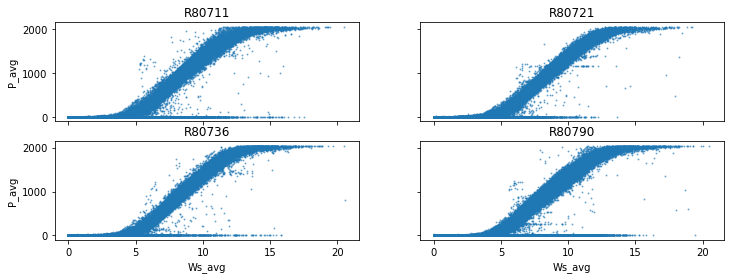

In [99]:
grouped = raw_complete.groupby(['Wind_turbine_name'])[['Ws_avg','P_avg']]

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4), sharey=True, sharex=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot.scatter(ax=ax,x='Ws_avg', y='P_avg', alpha=0.5, s=1)
    ax.set_title(key)

plt.show()

In [56]:
#raw_complete[(raw_complete.Wind_turbine_name.isin(["R80711"]))].loc['2014-03-30 01:00:00':'2014-03-30 03:00:00'].head()